In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps
)

/tmp/ipykernel_2239/589237677.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# TODO: 
# get age benchmark running
# mail denis
# mail joschka
# check offdiagonal age sources gap
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?
# accept a thresh as input (valid for eval)

In [107]:
base_dir = '/home/jovyan/experiments'
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval
exp_dir = os.path.join(base_dir, exp)

In [108]:
configs = read_result(exp_dir, 'config')

In [109]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,squash_outs,standardize_data,standardize_targets,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-17T16:24:10.124445,1,1,1,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age


In [110]:
assert configs['final_eval'].nunique() == 1

In [111]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20220429
0,tcn,age,0,20221017
0,tcn,age,0,20221018
0,tcn,age,0,20221019
0,tcn,age,0,20221020


In [112]:
scores = read_result(exp_dir, 'score')

In [113]:
if (configs['final_eval'] == '1').all():
    display(scores.loc[['mae']].mean())
else:
    display(scores.loc[['mae']].groupby('seed').mean())

train               2.585682e+00
eval                6.369889e+00
valid_not_normal    1.064924e+01
seed                2.022090e+07
valid_set_i         0.000000e+00
dtype: float64

In [114]:
histories = read_result(exp_dir, 'history')

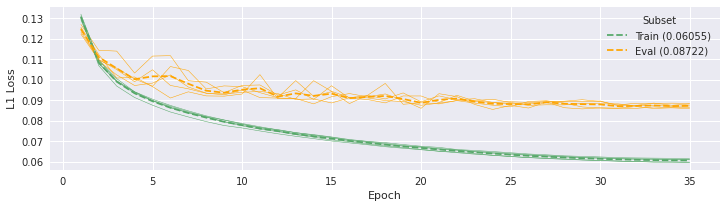

In [115]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        ax.set_title(f'Seed: {n1}')

In [116]:
preds = read_result(exp_dir, 'preds')

In [117]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
mean_acc

0.025507621033936823

In [118]:
bin_size = 2
max_age = 100
hist_max_count = 12#220

In [119]:
# TODO: mae here does not match mae from scores? why? fix
# it's due to the computation. scores are computed per fold and then averaged
# in plot below all preds of all folds are plotted and score computed on all of them
# which one to prefer?

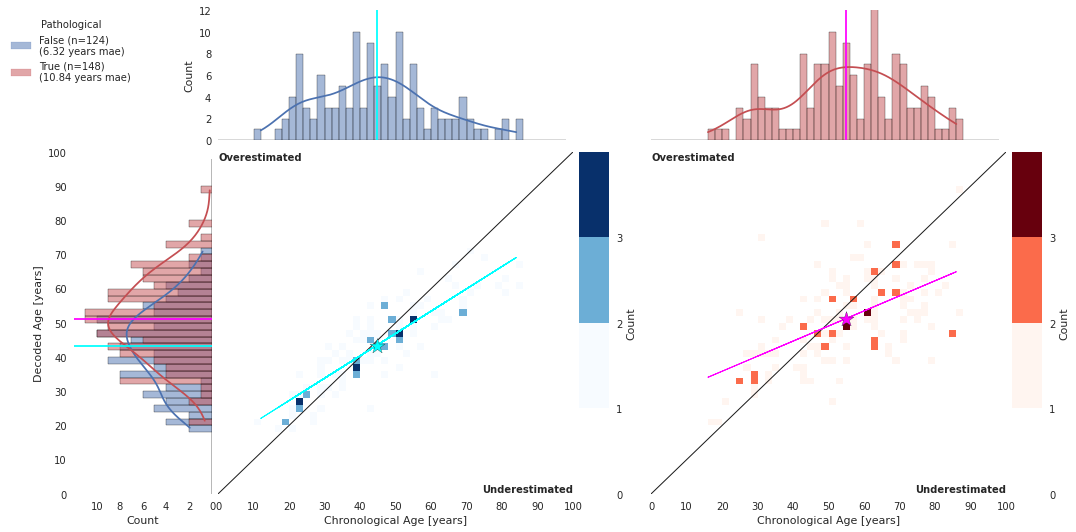

In [120]:
if (configs['final_eval'] == '1').all():
    this_preds = preds.reset_index()[['y_pred', 'y_true', 'pathological', 'index', 'subset']].groupby(['index', 'subset'], as_index=False).mean()
    fig = plot_heatmaps(this_preds, bin_size, max_age, hist_max_count)
else:
    for n1, g1 in preds.groupby('seed'):
        fig = plot_heatmaps(g1, bin_size, max_age, hist_max_count)
        fig.suptitle(f'Seed: {n1}', y=.9)
    # fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

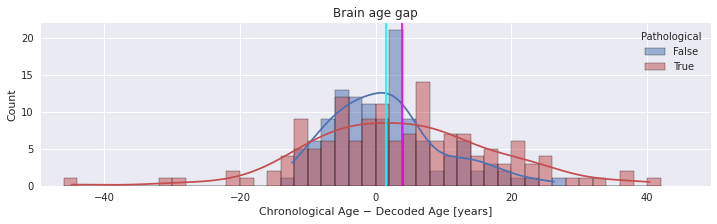

In [121]:
if (configs['final_eval'] == '1').all():
    this_preds = preds.reset_index()[['y_pred', 'y_true', 'pathological', 'gap', 'index', 'subset']].groupby(['index', 'subset'], as_index=False).mean()
    ax = plot_age_gap_hist(this_preds, bin_width=2)
#     ax.set_title(f'Subject-wise Pathological and Non-Pathological Brain Age Gap (Seed: {n1})')
else:
    for n1, g1 in preds.groupby('seed'):
        ax = plot_age_gap_hist(g1, bin_width=2)
        ax.set_title(f'Subject-wise Pathological and Non-Pathological Brain Age Gap (Seed: {n1})')

In [122]:
n_repetitions = 100000

In [123]:
# Mittlere Differenz der Brain Age Gaps

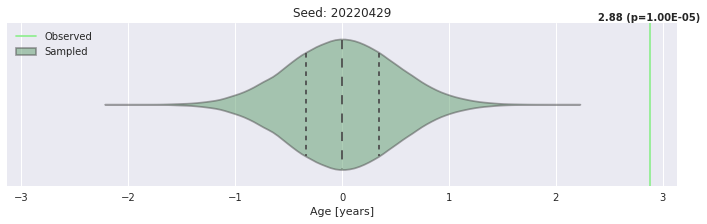

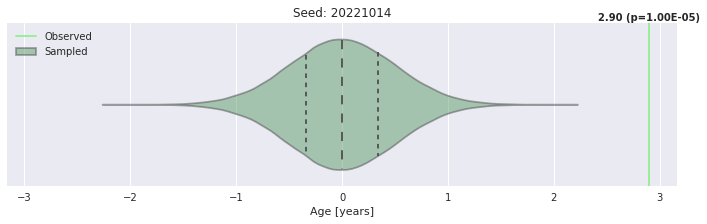

In [93]:
if (configs['final_eval'] == '1').all():
    this_preds = preds.reset_index()[['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']].groupby(['index', 'subset'], as_index=False).mean()
    observed, sampled = age_gap_diff_permutations(this_preds, n_repetitions, True)
    ax = plot_violin(
        observed,
        sampled, 
        'Age [years]',
    )
else:
    for n1, g1 in preds.groupby('seed'):
        observed, sampled = age_gap_diff_permutations(g1, n_repetitions, True)
        ax = plot_violin(
            observed,
            sampled, 
            'Age [years]',
        )
        ax.set_title(f'Seed: {n1}')
        # ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap');

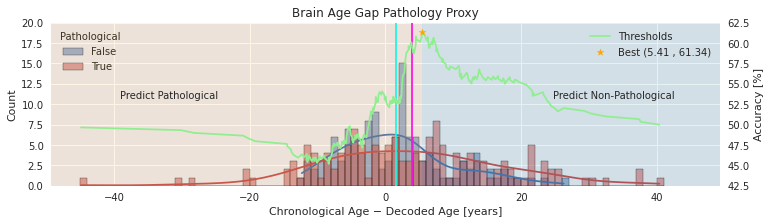

In [124]:
min_age, max_age = 0, 100
if (configs['final_eval'] == '1').all():
    this_preds = preds.reset_index()[['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']].groupby(['index', 'subset'], as_index=False).mean()
    ax = plot_thresh_to_acc(this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)] )
else:
    for n1, g1 in preds.groupby('seed'):
        ax = plot_thresh_to_acc(g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)] )
        ax.set_title('Brain Age Gap Pathology Proxy')

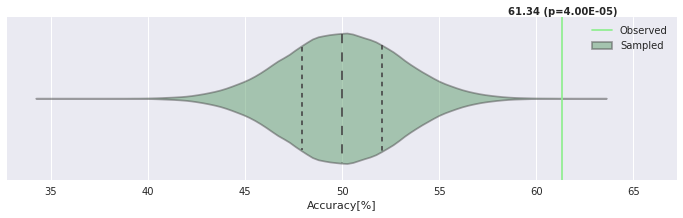

In [52]:
if (configs['final_eval'] == '1').all():
    this_preds = preds.reset_index()[['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']].groupby(['index', 'subset'], as_index=False).mean()
    observed, sampled = accuracy_perumtations(this_preds, n_repetitions)
    ax = plot_violin(
        observed,
        sampled,
        xlabel='Accuracy[%]',
        center_value=50,
    )
else:
    for n1, g1 in preds.groupby('seed'):
        observed, sampled = accuracy_perumtations(g1, n_repetitions)
        ax = plot_violin(
            observed,
            sampled,
            xlabel='Accuracy[%]',
            center_value=50,
        )
        # ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)

__analyze preds with targets >= 18 years -> improvement?__

In [28]:
preds = preds[preds.y_true >= 18]

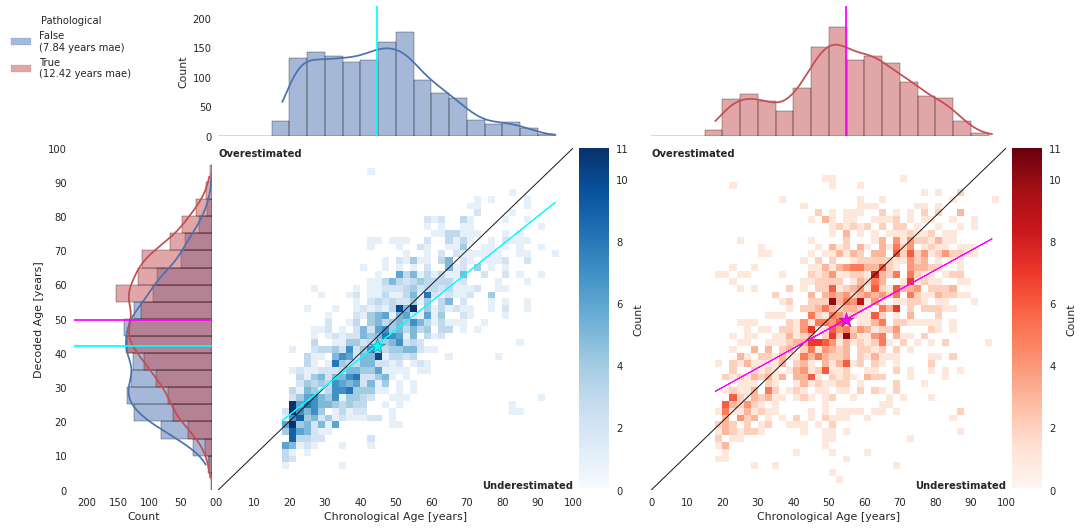

In [29]:
fig = plot_heatmaps(preds, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Subject-wise Pathological and Non-Pathological Brain Age Gap')

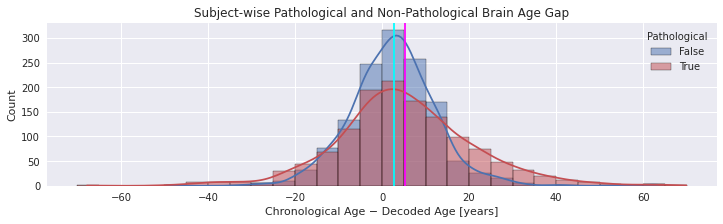

In [30]:
ax = plot_age_gap_hist(preds)
ax.set_title('Subject-wise Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

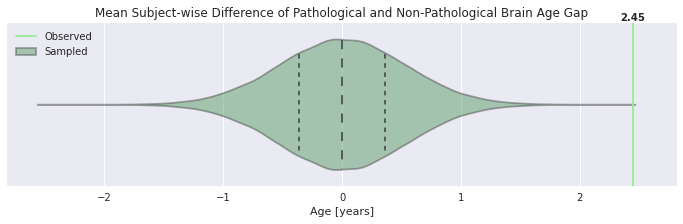

In [31]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, True), 
    'Age [years]',
)
ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

2015
7.835325027544705


Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

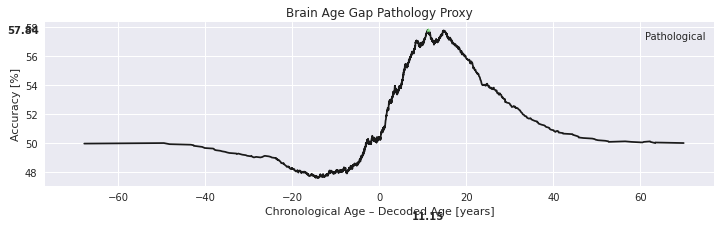

In [45]:
ax = plot_thresh_to_acc(preds)
ax.set_title('Brain Age Gap Pathology Proxy')

2015
7.835325027544705


Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

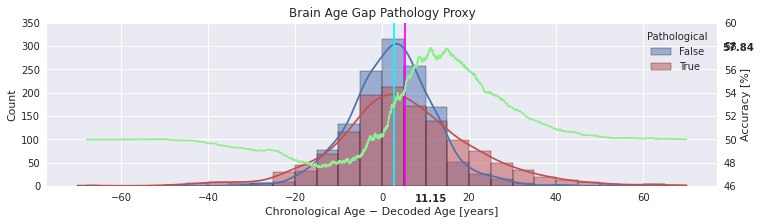

In [124]:
ax1 = plot_age_gap_hist(preds)
ax2 = ax1.twinx()
ax1.set_yticks(ax1.get_yticks())
ax2 = plot_thresh_to_acc(preds, ax=ax2)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax2.grid(None)
ax2.legend()
ax1.set_title('Brain Age Gap Pathology Proxy')
#ax1.set_xlabel('Chronological Age – Decoded Age [years]')
# ax2.axhline(50, linestyle='-', c='k', linewidth=1)

In [96]:
ages = [0, 18, 30, 60, 80, 100]

In [97]:
age_limits = [(ages[i], ages[j]) for i in range(len(ages)-1) for j in range(i+1, len(ages))]

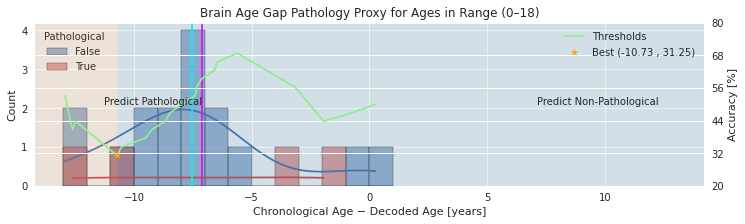

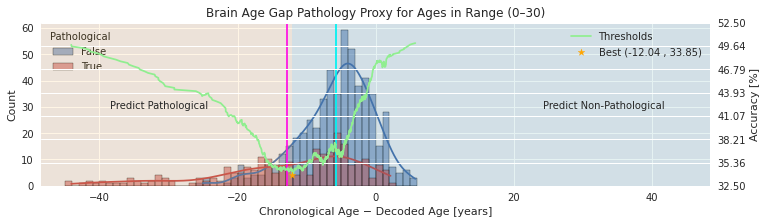

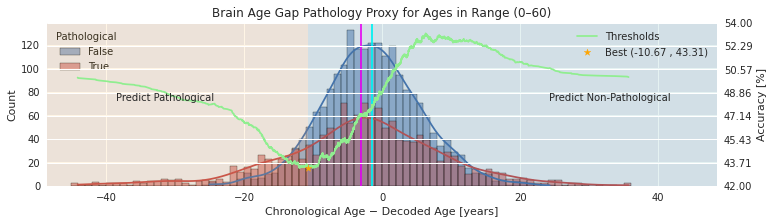

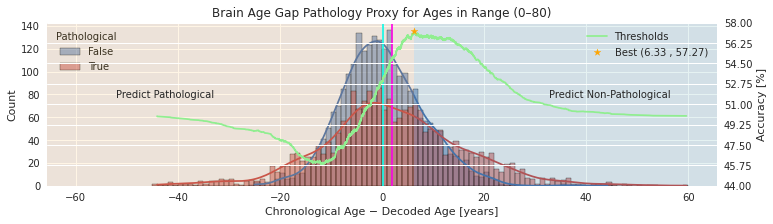

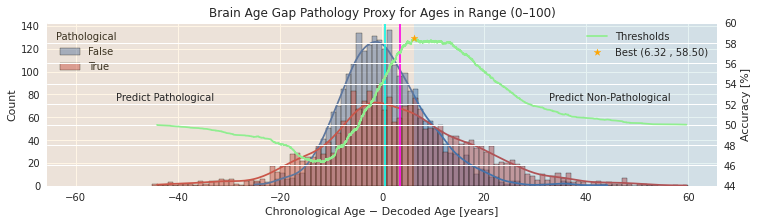

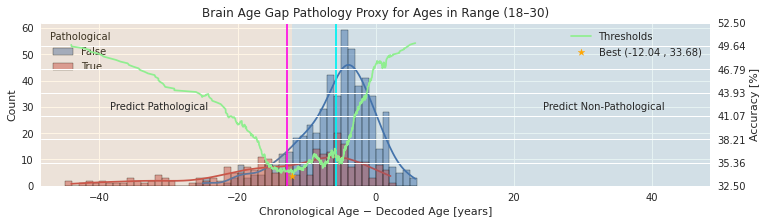

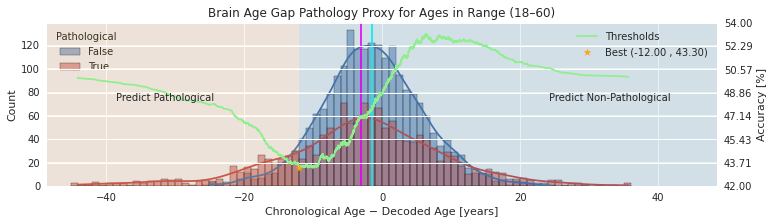

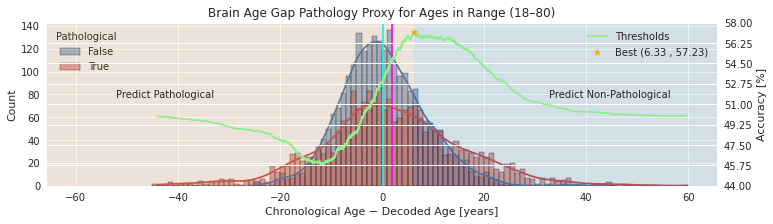

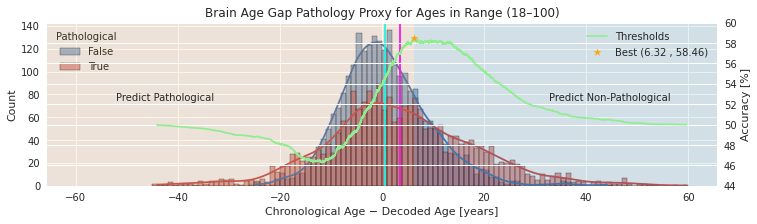

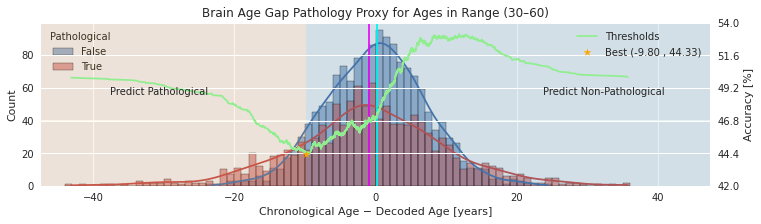

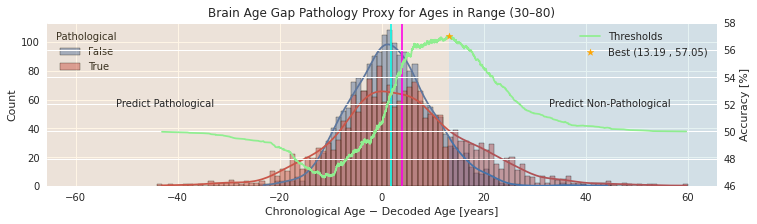

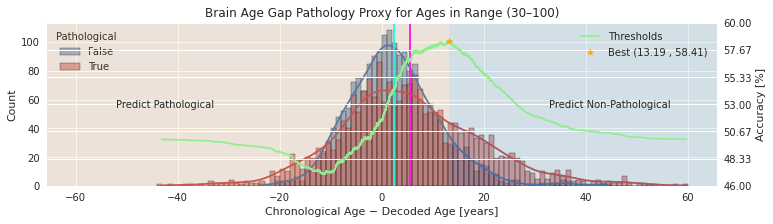

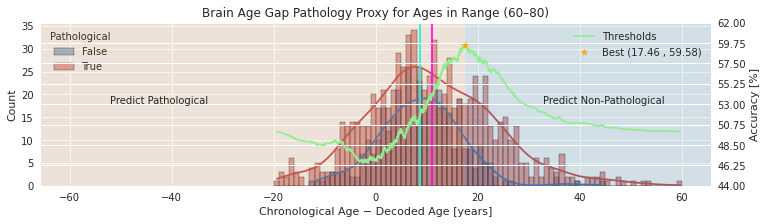

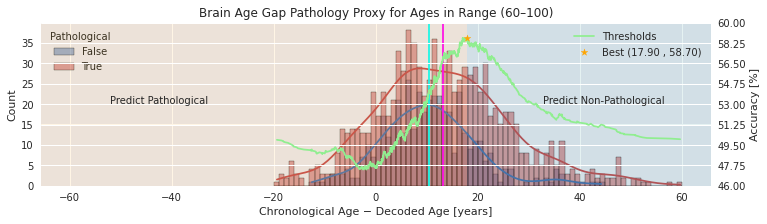

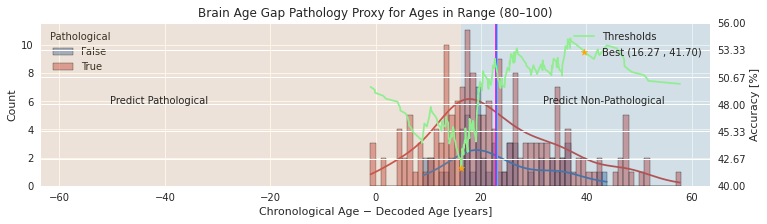

In [98]:
for min_age, max_age in age_limits:
    ax2 = plot_thresh_to_acc(preds[(preds.y_true >= min_age) & (preds.y_true < max_age)])
    ax2.set_title(ax2.get_title() + f' for Ages in Range ({min_age}–{max_age})')

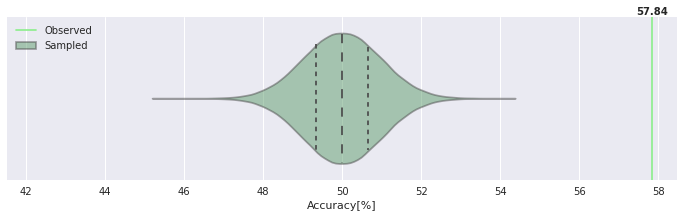

In [33]:
ax = plot_violin(
    *(accuracy_perumtations(preds, n_repetitions)),
    xlabel='Accuracy[%]',
    center_value=50,
)
# ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)